$\large\textbf{Lab 6.} $



$\large\textbf{Exercise 1 : Direct least squares loss minimization}$

$\large\textbf{Que 2 : [R] Write Python functions to compute the function value, gradient and Hessian of f(λ).}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
np.random.seed(1000)

In [3]:
A = np.random.randn(800, 2)
x1= np.random.uniform(low=-4,high=-2,size=None)
x2= np.random.uniform(low=6,high=8,size=None)
x_bar = np.random.uniform(low=x1, high=x2, size=(1,2))
x_bar = x_bar.T
epsilon = np.random.randn(800, 1)
A_x = np.matmul(A, x_bar)
y = A_x + epsilon


In [4]:
 def evalf(x,lam):  
  assert type(x) is np.ndarray   
  fval = np.linalg.norm(np.matmul(A,x) - y)
  fval = 0.5 * (fval)**2+(lam/2)*np.matmul(x.T,x)
  return (fval)


In [5]:
def evalg(x,lam):
  assert type(x) is np.ndarray 
  grad=(lam*x+np.matmul(A.T, np.matmul(A, x) - y))
  return grad

In [6]:
def evalh(x,lam):
  assert type(x) is np.ndarray  
  return np.matmul(A.T,A)+lam*np.identity(2)

In [7]:
def compute_B_k(s, y, B_k):
  I=np.identity(2)
  assert type(s) is np.ndarray 
  assert type(y) is np.ndarray 
  assert type(B_k) is np.ndarray
  mu = 1 / np.dot(np.squeeze(np.asarray(y)), np.squeeze(np.asarray(s)))
  a1 = np.outer(np.multiply(mu, s), np.transpose(y))
  a2 = np.outer(np.multiply(mu, y), np.transpose(s))
  a = np.subtract(I, a1)
  b = np.subtract(I, a2)
  c = np.outer(np.multiply(mu, s), np.transpose(s))
  d = np.matmul(np.matmul(a, B_k), b)
  z = np.add(d, c)
  return z

In [8]:
#line search type 
CONSTANT_STEP_LENGTH = 3
BACKTRACKING_LINE_SEARCH = 2
EXACT_LINE_SEARCH = 1

In [9]:
def compute_D_k(x):
  assert type(x) is np.ndarray
  mat = evalh(x)
  return np.linalg.inv(mat)

In [10]:
def compute_steplength_backtracking_scaled_direction(x, lam,gradf, alpha_start, rho, gamma, B_k): 
  assert type(x) is np.ndarray
  assert type(gradf) is np.ndarray
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  alpha = alpha_start
  p = - gradf
  D_k = B_k
  
  while evalf(x + alpha*np.matmul(D_k,p),lam) > evalf(x,lam) + gamma * alpha* (np.matmul(np.matrix.transpose(gradf), np.matmul(D_k,p)) ):
    alpha = alpha * rho
  return alpha 

In [11]:
def find_minimizer_Newtonmethod(start_x,lam, tol, line_search_type, *args):
  assert type(start_x) is np.ndarray  
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,lam)
  h_x = evalh(x,lam)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])
  k = 0
  x_array_newton = []
  f_array_newton = []
  while (np.linalg.norm(g_x) > tol): 
    D_k = np.linalg.inv(evalh(x,lam))
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x,lam, g_x, alpha_start, rho, gamma, D_k)
    elif line_search_type == CONSTANT_STEP_LENGTH: 
      step_length = 1.0
    else:
      raise ValueError('Line search type unknown. Please check!')
    x_array_newton.append(math.log(np.linalg.norm(x - x_bar)))
    f_array_newton.append(math.log(np.linalg.norm(evalf(x,lam) - evalf(x_bar,lam))))  
    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x))) 
    k = k + 1
    g_x = evalg(x,lam) 
  return x,  k, x_array_newton, f_array_newton

In [12]:
def find_minimizer_BFGS_scaling(start_x, lam,tol, line_search_type, *args):
  assert type(start_x) is np.ndarray 
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,lam)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  B_k = np.identity(2)
  x_old = x
  x_array_bfgs = []
  f_array_bfgs = []
  while (np.linalg.norm(g_x) > tol): 
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x_old,lam, g_x, alpha_start, rho, gamma, B_k)
    elif line_search_type == CONSTANT_STEP_LENGTH: 
      step_length = 1.
    else:
      raise ValueError('Line search type unknown. Please check!')
    x_array_bfgs.append(math.log(np.linalg.norm(x_old - x_bar)))
    f_array_bfgs.append(math.log(np.linalg.norm(evalf(x_old,lam) - evalf(x_bar,lam))))
    x_new = np.subtract(x_old, np.multiply(step_length, np.matmul(B_k,g_x))) 
    g_x = evalg(x_new,lam)
    s = np.subtract(x_new, x_old)
    y = np.subtract(evalg(x_new,lam), evalg(x_old,lam)) 
    B_k = compute_B_k(s, y, B_k)
    x_old = x_new
    k = k + 1
  return x_new, k, x_array_bfgs, f_array_bfgs

$\large\textbf{Que 3 : [R]}$ Fixing λ = 1, solve the problem (2) using Newton and BFGS method with backtracking line search (use
$α^0$ = 0.9, $\rho$ = 0.5, $\gamma$ = 0.5 for backtracking line search and $\tau$ = 10−5
). Try the following different starting point
values for each method: $x^0$ =[0,0] and $x^0$ =[50,50] and $x^0$ =[-5,-5] 

$\large\textbf{Ans: }$

In [13]:
alpha = 0.9
rho = 0.5
gamma = 0.5
my_tol= 1e-5
lam=1
k1=[]
xvalues=[]
fvalues=[]
my_start_x =np.array([[0,0],[50,50],[-5,-5]])
for i in my_start_x:
  x, k, x_array_newton, f_array_newton = find_minimizer_Newtonmethod(i.reshape((2,1)),lam, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
  print('for starting with',i,':\nwe have minimizer:',x ,'\nno. of iterations:',k, '\n log(x^k-x^*):',x_array_newton , '\n log(x^k-x^*):',f_array_newton)
  k1.append(k)
  xvalues.append(x_array_newton)
  fvalues.append(f_array_newton)

for starting with [0 0] :
we have minimizer: [[-0.28742443]
 [ 0.81706335]] 
no. of iterations: 8 
 log(x^k-x^*): [-0.13726969574263953, -2.366518535848815, -3.770595829915061, -3.947900343643544, -3.960358439407866, -3.961529234123002, -3.96164554179965, -3.961657164828069] 
 log(x^k-x^*): [5.717161075321207, 1.0613119018214798, -2.109127661794652, -1.8874415595588678, -1.8854552017676565, -1.8854353581015044, -1.8854351596677192, -1.8854351576829582]
for starting with [50 50] :
we have minimizer: [[-0.28742443]
 [ 0.81706337]] 
no. of iterations: 10 
 log(x^k-x^*): [4.253080146542213, 1.9480832593408737, -0.3789376596776765, -2.9643360080288486, -4.412948125393508, -3.998881313438041, -3.965320412097251, -3.9620240624091165, -3.961695010930689, -3.9616621116041877] 
 log(x^k-x^*): [14.54377118197495, 9.938593742896074, 5.332697982031992, 0.6521749388225508, -2.0321896365070717, -1.886801030438227, -1.8854488071595898, -1.8854352941569097, -1.8854351590276066, -1.8854351576758417]
for

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


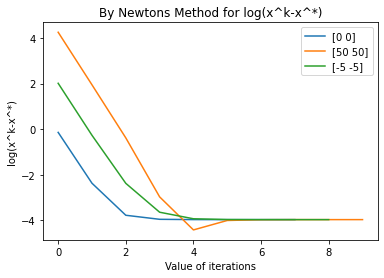

In [14]:
for j in range(len(k1)):
  plt.plot([i for i in range(k1[j])],xvalues[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(x^k-x^*)')
  plt.title('By Newtons Method for log(x^k-x^*)')
  plt.legend(my_start_x)
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


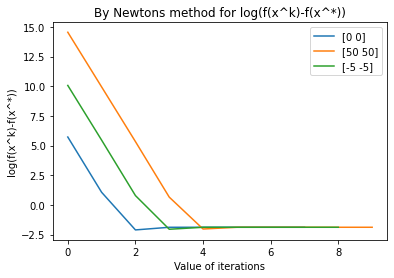

In [15]:
for j in range(len(k1)):
  plt.plot([i for i in range(k1[j])],fvalues[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(f(x^k)-f(x^*))')
  plt.legend(my_start_x)
  plt.title('By Newtons method for log(f(x^k)-f(x^*))')
plt.show()

$\large\textbf{Que 3 : [R]}$ Fixing λ = 1, solve the problem (2) using Newton and BFGS method with backtracking line search (use
$α^0$ = 0.9, $\rho$ = 0.5, $\gamma$ = 0.5 for backtracking line search and $\tau$ = 10−5
). Try the following different starting point
values for each method: $x^0$ =[0,0] and $x^0$ =[50,50] and $x^0$ =[-5,-5] 

In [16]:
alpha = 0.9
rho = 0.5
gamma = 0.5
my_tol= 1e-5
lam=1
k2=[]
xvalues1=[]
fvalues1=[]
my_start_x =np.array([[0,0],[50,50],[-5,-5]])
for i in my_start_x:
  x, k, x_array_newton, f_array_newton = find_minimizer_BFGS_scaling(i.reshape((2,1)),lam, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
  print('for starting with',i,':\nwe have minimizer:',x ,'\nno. of iterations:',k, '\n log(x^k-x^*):',x_array_newton , '\n log(x^k-x^*):',f_array_newton)
  k2.append(k)
  xvalues1.append(x_array_newton)
  fvalues1.append(f_array_newton)

for starting with [0 0] :
we have minimizer: [[-0.28742443]
 [ 0.81706336]] 
no. of iterations: 10 
 log(x^k-x^*): [-0.13726969574263953, -1.368494366724729, -1.3676471182022363, -3.3898172361204035, -3.926842545044209, -3.958769809775471, -3.961375921965447, -3.96163026644321, -3.9616556378513685, -3.961658174361418] 
 log(x^k-x^*): [5.717161075321207, 3.2168830820482124, 3.2124160136468016, -2.5348442926073163, -1.9007755389581362, -1.8855874024213592, -1.8854366799953513, -1.8854351728860994, -1.8854351578148012, -1.8854351576646051]
for starting with [50 50] :
we have minimizer: [[-0.28742443]
 [ 0.81706337]] 
no. of iterations: 11 
 log(x^k-x^*): [4.253080146542213, 2.920872383427596, 2.917532114759155, 0.04158578485597038, -2.4162938034631973, -4.545878374030336, -4.0125637818519815, -3.966662811649069, -3.9621580394419937, -3.9617084060012746, -3.961663451084919] 
 log(x^k-x^*): [14.54377118197495, 11.88068108705415, 11.874567089792226, 6.146190844970211, 1.5080033870327332, -2.

In [17]:
for j in range(len(k2)):
  plt.plot([i for i in range(k2[j])],xvalues1[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(x^k-x^*)')
  plt.title('By Newtons Method for log(x^k-x^*)')
  plt.legend(my_start_x)
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


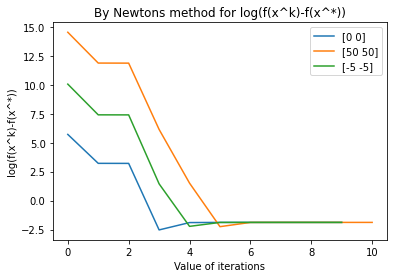

In [18]:
for j in range(len(k2)):
  plt.plot([i for i in range(k2[j])],fvalues1[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(f(x^k)-f(x^*))')
  plt.legend(my_start_x)
  plt.title('By Newtons method for log(f(x^k)-f(x^*))')
plt.show()

$\large\textbf{Ans : }$ here we saw above in both graphs that the sequence are converging towards a particular value. hence both sequences are Q-linear,Q superlinear and Q-quadratic . Also we can see that no. of iterations decrease constantly. and also we saw  in BFGS method convergence is slow as compared to newtons method. Hence the value of iterations increases or converges slowly for BFGS method.



$\Large{Ques-4}$

In [19]:
alpha = 0.9
rho = 0.5
gamma = 0.5
my_tol= 1e-5
k2=[]
xvalues1=[]
fvalues1=[]
my_start_x =np.zeros((2,1))
lam=np.array([10**(-3),0.1,1.0,10.0,100.0])
for i in lam:
  x, k, x_array_newton, f_array_newton = find_minimizer_Newtonmethod(my_start_x,i, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
  print('for lambda',i,':\nwe have minimizer:',x ,'\nno. of iterations:',k, '\n log(x^k-x^*):',x_array_newton , '\n log(x^k-x^*):',f_array_newton)
  k2.append(k)
  xvalues1.append(x_array_newton)
  fvalues1.append(f_array_newton)

for lambda 0.001 :
we have minimizer: [[-0.2877885 ]
 [ 0.81806786]] 
no. of iterations: 8 
 log(x^k-x^*): [-0.13726969574263953, -2.376602729540744, -3.7979551838064194, -3.964099688795888, -3.974621938961831, -3.9755913212016365, -3.9756874115298, -3.975697012064758] 
 log(x^k-x^*): [5.718408752078776, 1.0641254905645725, -2.146308277127944, -1.9168659096885114, -1.9148177763842074, -1.9147973162195027, -1.9147971116210611, -1.9147971095748455]
for lambda 0.1 :
we have minimizer: [[-0.28775238]
 [ 0.8179682 ]] 
no. of iterations: 8 
 log(x^k-x^*): [-0.13726969574263953, -2.3755979310405397, -3.7952719908430996, -3.9626097622074186, -3.9733327132270837, -3.9743229048510367, -3.9744210832467597, -3.974430892659476] 
 log(x^k-x^*): [5.71828517790274, 1.0638611350787972, -2.142913451077536, -1.914191152587789, -1.9121487340260863, -1.9121283308921362, -1.9121281268632722, -1.9121281248221258]
for lambda 1.0 :
we have minimizer: [[-0.28742443]
 [ 0.81706335]] 
no. of iterations: 8 
 log(x

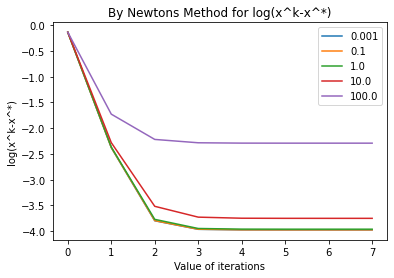

In [21]:
for j in range(len(k2)):
  plt.plot([i for i in range(k2[j])],xvalues1[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(x^k-x^*)')
  plt.title('By Newtons Method for log(x^k-x^*)')
  plt.legend(lam)
plt.show()

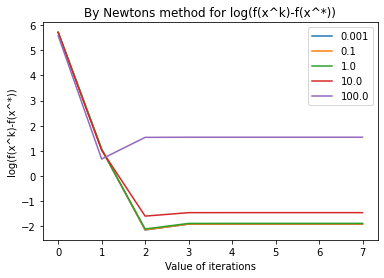

In [22]:
for j in range(len(k2)):
  plt.plot([i for i in range(k2[j])],fvalues1[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(f(x^k)-f(x^*))')
  plt.legend(lam)
  plt.title('By Newtons method for log(f(x^k)-f(x^*))')
plt.show()



$\large\textbf{Ans 4: }$ here we saw above in both graphs that the sequence are converging towards a particular value. hence both sequences are Q-linear,Q superlinear and Q-quadratic . Also we can see that no. of iterations decrease constantly. and also we saw  in BFGS method convergence is slow as compared to newtons method. Hence the value of iterations increases or converges slowly for BFGS method.


In [23]:
alpha = 0.9
rho = 0.5
gamma = 0.5
my_tol= 1e-5
k3=[]
xvalues2=[]
fvalues2=[]
my_start_x =np.zeros((2,1))
lam=np.array([10**(-3),0.1,1.0,10.0,100.0])
for i in lam:
  x, k, x_array_newton, f_array_newton = find_minimizer_BFGS_scaling(my_start_x,i, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
  print('for lambda',i,':\nwe have minimizer:',x ,'\nno. of iterations:',k, '\n log(x^k-x^*):',x_array_newton , '\n log(x^k-x^*):',f_array_newton)
  k3.append(k)
  xvalues2.append(x_array_newton)
  fvalues2.append(f_array_newton)

for lambda 0.001 :
we have minimizer: [[-0.2877885 ]
 [ 0.81806787]] 
no. of iterations: 10 
 log(x^k-x^*): [-0.13726969574263953, -1.368494366724729, -1.3676504475731348, -3.43003716394475, -3.947776209226291, -3.97353317509636, -3.975488183277148, -3.975677155387579, -3.9756959870272994, -3.9756978695352805] 
 log(x^k-x^*): [5.718408752078776, 3.2244373230502887, 3.2199726820817123, -2.5918952463629727, -1.9299926255536517, -1.9149479273940617, -1.9147986176195446, -1.9147971246346842, -1.9147971097048313, -1.9147971095559455]
for lambda 0.1 :
we have minimizer: [[-0.28775238]
 [ 0.81796821]] 
no. of iterations: 11 
 log(x^k-x^*): [-0.13726969574263953, -1.368494366724729, -1.367650117365707, -3.4259918631730533, -3.9458075486318562, -3.972193923254282, -3.9742147510216554, -3.974410325390124, -3.974429817449345, -3.974431766001205, -3.9744318147134803] 
 log(x^k-x^*): [5.71828517790274, 3.2236912468423995, 3.2192263738009816, -2.58560192496296, -1.9273423737099054, -1.91227912717176

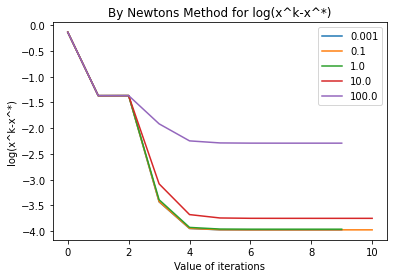

In [24]:
for j in range(len(k3)):
  plt.plot([i for i in range(k3[j])],xvalues2[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(x^k-x^*)')
  plt.title('By Newtons Method for log(x^k-x^*)')
  plt.legend(lam)
plt.show()

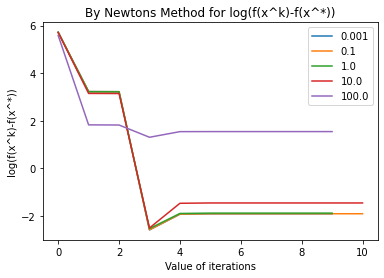

In [25]:
for j in range(len(k3)):
  plt.plot([i for i in range(k3[j])],fvalues2[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(f(x^k)-f(x^*))')
  plt.title('By Newtons Method for log(f(x^k)-f(x^*))')
  plt.legend(lam)
plt.show()

$\large\textbf{Ans 4 : }$ here we saw above in both graphs that the sequence are converging towards a particular value. hence both sequences are Q-linear,Q superlinear and Q-quadratic . Also we can see that no. of iterations decrease constantly. and also we saw  in BFGS method convergence is slow as compared to newtons method. Hence the value of iterations increases or converges slowly for BFGS method.

In [26]:
A1 = np.random.randn(2400, 2)
x1= np.random.uniform(low=-4,high=-2,size=None)
x2= np.random.uniform(low=6,high=8,size=None)
x_bar = np.random.uniform(low=x1, high=x2, size=(1,2))
x_bar = x_bar.T
epsilon = np.random.randn(2400, 1)
A_x = np.matmul(A1, x_bar)
y = A_x + epsilon

In [27]:
 def evalf(x,lam):  
  assert type(x) is np.ndarray   
  fval = np.linalg.norm(np.matmul(A1,x) - y)
  fval = 0.5 * (fval)**2+(lam/2)*np.matmul(x.T,x)
  return (fval)


In [28]:
def evalg(x,lam):
  assert type(x) is np.ndarray 
  grad=(lam*x+np.matmul(A1.T, np.matmul(A1, x) - y))
  return grad

In [29]:
def evalh(x,lam):
  assert type(x) is np.ndarray  
  return np.matmul(A1.T,A1)+lam*np.identity(2)

In [30]:
def compute_B_k(s, y, B_k):
  I=np.identity(2)
  assert type(s) is np.ndarray 
  assert type(y) is np.ndarray 
  assert type(B_k) is np.ndarray
  mu = 1 / np.dot(np.squeeze(np.asarray(y)), np.squeeze(np.asarray(s)))
  a1 = np.outer(np.multiply(mu, s), np.transpose(y))
  a2 = np.outer(np.multiply(mu, y), np.transpose(s))
  a = np.subtract(I, a1)
  b = np.subtract(I, a2)
  c = np.outer(np.multiply(mu, s), np.transpose(s))
  d = np.matmul(np.matmul(a, B_k), b)
  z = np.add(d, c)
  return z

In [31]:
#line search type 
CONSTANT_STEP_LENGTH = 3
BACKTRACKING_LINE_SEARCH = 2
EXACT_LINE_SEARCH = 1

In [32]:
def compute_D_k(x):
  assert type(x) is np.ndarray
  mat = evalh(x)
  return np.linalg.inv(mat)

In [33]:
def compute_steplength_backtracking_scaled_direction(x, lam,gradf, alpha_start, rho, gamma, B_k): 
  assert type(x) is np.ndarray
  assert type(gradf) is np.ndarray
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  alpha = alpha_start
  p = - gradf
  D_k = B_k
  
  while evalf(x + alpha*np.matmul(D_k,p),lam) > evalf(x,lam) + gamma * alpha* (np.matmul(np.matrix.transpose(gradf), np.matmul(D_k,p)) ):
    alpha = alpha * rho
  return alpha 

In [34]:
def find_minimizer_Newtonmethod1(start_x,lam, tol, line_search_type, *args):
  assert type(start_x) is np.ndarray  
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,lam)
  h_x = evalh(x,lam)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])
  k = 0
  x_array_newton = []
  f_array_newton = []
  while (np.linalg.norm(g_x) > tol): 
    D_k = np.linalg.inv(evalh(x,lam))
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x,lam, g_x, alpha_start, rho, gamma, D_k)
    elif line_search_type == CONSTANT_STEP_LENGTH: 
      step_length = 1.0
    else:
      raise ValueError('Line search type unknown. Please check!')
    x_array_newton.append(math.log(np.linalg.norm(x - x_bar)))
    f_array_newton.append(math.log(np.linalg.norm(evalf(x,lam) - evalf(x_bar,lam))))  
    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x))) 
    k = k + 1
    g_x = evalg(x,lam) 
  return x,  k, x_array_newton, f_array_newton

In [35]:
def find_minimizer_BFGS_scaling1(start_x, lam,tol, line_search_type, *args):
  assert type(start_x) is np.ndarray 
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,lam)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  B_k = np.identity(2)
  x_old = x
  x_array_bfgs = []
  f_array_bfgs = []
  while (np.linalg.norm(g_x) > tol): 
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x_old,lam, g_x, alpha_start, rho, gamma, B_k)
    elif line_search_type == CONSTANT_STEP_LENGTH: 
      step_length = 1.
    else:
      raise ValueError('Line search type unknown. Please check!')
    x_array_bfgs.append(math.log(np.linalg.norm(x_old - x_bar)))
    f_array_bfgs.append(math.log(np.linalg.norm(evalf(x_old,lam) - evalf(x_bar,lam))))
    x_new = np.subtract(x_old, np.multiply(step_length, np.matmul(B_k,g_x))) 
    g_x = evalg(x_new,lam)
    s = np.subtract(x_new, x_old)
    y = np.subtract(evalg(x_new,lam), evalg(x_old,lam)) 
    B_k = compute_B_k(s, y, B_k)
    x_old = x_new
    k = k + 1
  return x_new, k, x_array_bfgs, f_array_bfgs

$\Large{Ques-5}$

In [36]:
alpha = 0.9
rho = 0.5
gamma = 0.5
my_tol= 1e-5
k2=[]
xvalues1=[]
fvalues1=[]
my_start_x =np.zeros((2,1))
lam=np.array([10**(-3),0.1,1.0,10.0,100.0])
for i in lam:
  x, k, x_array_newton, f_array_newton = find_minimizer_Newtonmethod1(my_start_x,i, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
  print('for lambda',i,':\nwe have minimizer:',x ,'\nno. of iterations:',k, '\n log(x^k-x^*):',x_array_newton , '\n log(x^k-x^*):',f_array_newton)
  k2.append(k)
  xvalues1.append(x_array_newton)
  fvalues1.append(f_array_newton)

for lambda 0.001 :
we have minimizer: [[4.76659696]
 [5.2577851 ]] 
no. of iterations: 10 
 log(x^k-x^*): [1.9616028489660449, -0.32287234795022346, -2.415960088384204, -3.3560465263393193, -3.4592273800087696, -3.468504924109392, -3.4694190708498938, -3.469510346013244, -3.4695194721310356, -3.469520384728832] 
 log(x^k-x^*): [11.015907581650573, 6.408817026840963, 1.5901795840079056, 0.11160747688715952, 0.1640735195981018, 0.16458452359205075, 0.16458963231347595, 0.16458968340088628, 0.16458968391198603, 0.1645896839168077]
for lambda 0.1 :
we have minimizer: [[4.76639677]
 [5.25757385]] 
no. of iterations: 10 
 log(x^k-x^*): [1.9616028489660449, -0.3225107111774147, -2.4128771602141845, -3.3508851462691167, -3.454742783063857, -3.4641259608975505, -3.4650510935037304, -3.465143471510671, -3.4651527079554265, -3.465153631586335] 
 log(x^k-x^*): [11.015866438945451, 6.408759695636008, 1.5881122893417643, 0.12040709535396343, 0.17242315484902668, 0.17292989022485478, 0.17293495628249

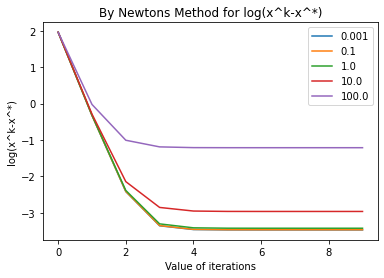

In [37]:
for j in range(len(k2)):
  plt.plot([i for i in range(k2[j])],xvalues1[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(x^k-x^*)')
  plt.title('By Newtons Method for log(x^k-x^*)')
  plt.legend(lam)
plt.show()

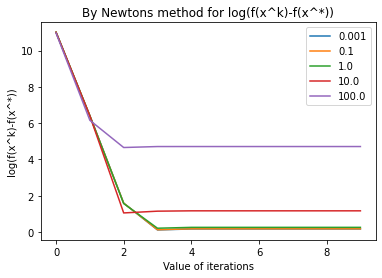

In [38]:
for j in range(len(k2)):
  plt.plot([i for i in range(k2[j])],fvalues1[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(f(x^k)-f(x^*))')
  plt.legend(lam)
  plt.title('By Newtons method for log(f(x^k)-f(x^*))')
plt.show()

In [39]:
alpha = 0.9
rho = 0.5
gamma = 0.5
my_tol= 1e-5
k3=[]
xvalues2=[]
fvalues2=[]
my_start_x =np.zeros((2,1))
lam=np.array([10**(-3),0.1,1.0,10.0,100.0])
for i in lam:
  x, k, x_array_newton, f_array_newton = find_minimizer_BFGS_scaling1(my_start_x,i, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
  print('for lambda',i,':\nwe have minimizer:',x ,'\nno. of iterations:',k, '\n log(x^k-x^*):',x_array_newton , '\n log(x^k-x^*):',f_array_newton)
  k3.append(k)
  xvalues2.append(x_array_newton)
  fvalues2.append(f_array_newton)

for lambda 0.001 :
we have minimizer: [[4.76659696]
 [5.2577851 ]] 
no. of iterations: 13 
 log(x^k-x^*): [1.9616028489660449, 1.207618366924998, 1.204335208533307, 0.46581185559693894, -1.75210671013876, -3.2087680555107494, -3.4473801836048477, -3.4673772074447715, -3.4693069028856414, -3.4694991352878097, -3.4695183511192367, -3.4695202726282415, -3.469520368703344] 
 log(x^k-x^*): [11.015907581650573, 9.501838745841821, 9.498550303161197, 8.012284530263402, 3.3676721340166345, -0.1312356842154158, 0.16202557267491727, 0.16456407532171402, 0.16458942783381558, 0.16458968135610155, 0.16458968389096343, 0.16458968391661485, 0.1645896839168077]
for lambda 0.1 :
we have minimizer: [[4.76639677]
 [5.25757385]] 
no. of iterations: 13 
 log(x^k-x^*): [1.9616028489660449, 1.207618366924998, 1.2043353570318205, 0.46591575555678655, -1.7505123468374584, -3.2034034394483326, -3.442754362560882, -3.4629824636335367, -3.4649373306287408, -3.465132101125407, -3.465151570975938, -3.465153517888970

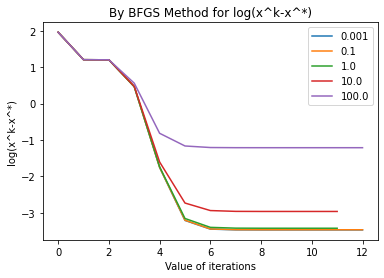

In [40]:
for j in range(len(k3)):
  plt.plot([i for i in range(k3[j])],xvalues2[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(x^k-x^*)')
  plt.title('By BFGS Method for log(x^k-x^*)')
  plt.legend(lam)
plt.show()

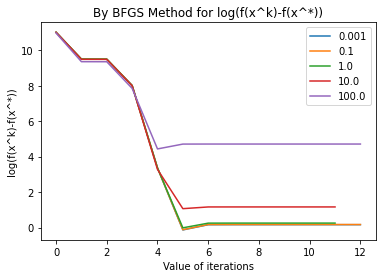

In [41]:
for j in range(len(k3)):
  plt.plot([i for i in range(k3[j])],fvalues2[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(f(x^k)-f(x^*))')
  plt.title('By BFGS Method for log(f(x^k)-f(x^*))')
  plt.legend(lam)
plt.show()

$\large\textbf{Ans 5: }$ here we saw above in both graphs that the sequence are converging towards a particular value. hence both sequences are Q-linear,Q superlinear and Q-quadratic . Also we can see that no. of iterations decrease constantly. and also we saw  in BFGS method convergence is slow as compared to newtons method. Hence the value of iterations increases or converges slowly for BFGS method.

$\Large{Ques-6}$

In [42]:
np.random.seed(9000)
A2 = np.random.randn(9600, 2)
x1= np.random.uniform(low=-4,high=-2,size=None)
x2= np.random.uniform(low=6,high=8,size=None)
x_bar = np.random.uniform(low=x1, high=x2, size=(1,2))
x_bar = x_bar.T
epsilon = np.random.randn(9600, 1)
A_x = np.matmul(A2, x_bar)
y = A_x + epsilon

In [43]:
 def evalf(x,lam):  
  assert type(x) is np.ndarray   
  fval = np.linalg.norm(np.matmul(A2,x) - y)
  fval = 0.5 * (fval)**2+(lam/2)*np.matmul(x.T,x)
  return (fval)


In [44]:
def evalg(x,lam):
  assert type(x) is np.ndarray 
  grad=(lam*x+np.matmul(A2.T, np.matmul(A2, x) - y))
  return grad

In [45]:
def evalh(x,lam):
  assert type(x) is np.ndarray  
  return np.matmul(A2.T,A2)+lam*np.identity(2)

In [46]:
def compute_B_k(s, y, B_k):
  I=np.identity(2)
  assert type(s) is np.ndarray 
  assert type(y) is np.ndarray 
  assert type(B_k) is np.ndarray
  mu = 1 / np.dot(np.squeeze(np.asarray(y)), np.squeeze(np.asarray(s)))
  a1 = np.outer(np.multiply(mu, s), np.transpose(y))
  a2 = np.outer(np.multiply(mu, y), np.transpose(s))
  a = np.subtract(I, a1)
  b = np.subtract(I, a2)
  c = np.outer(np.multiply(mu, s), np.transpose(s))
  d = np.matmul(np.matmul(a, B_k), b)
  z = np.add(d, c)
  return z

In [47]:
#line search type 
CONSTANT_STEP_LENGTH = 3
BACKTRACKING_LINE_SEARCH = 2
EXACT_LINE_SEARCH = 1

In [48]:
def compute_D_k(x):
  assert type(x) is np.ndarray
  mat = evalh(x)
  return np.linalg.inv(mat)

In [49]:
def compute_steplength_backtracking_scaled_direction(x, lam,gradf, alpha_start, rho, gamma, B_k): 
  assert type(x) is np.ndarray
  assert type(gradf) is np.ndarray
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  alpha = alpha_start
  p = - gradf
  D_k = B_k
  
  while evalf(x + alpha*np.matmul(D_k,p),lam) > evalf(x,lam) + gamma * alpha* (np.matmul(np.matrix.transpose(gradf), np.matmul(D_k,p)) ):
    alpha = alpha * rho
  return alpha 

In [50]:
def find_minimizer_Newtonmethod2(start_x,lam, tol, line_search_type, *args):
  assert type(start_x) is np.ndarray  
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,lam)
  h_x = evalh(x,lam)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])
  k = 0
  x_array_newton = []
  f_array_newton = []
  while (np.linalg.norm(g_x) > tol): 
    D_k = np.linalg.inv(evalh(x,lam))
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x,lam, g_x, alpha_start, rho, gamma, D_k)
    elif line_search_type == CONSTANT_STEP_LENGTH: 
      step_length = 1.0
    else:
      raise ValueError('Line search type unknown. Please check!')
    x_array_newton.append(math.log(np.linalg.norm(x - x_bar)))
    f_array_newton.append(math.log(np.linalg.norm(evalf(x,lam) - evalf(x_bar,lam))))  
    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x))) 
    k = k + 1
    g_x = evalg(x,lam) 
  return x,  k, x_array_newton, f_array_newton

In [51]:
def find_minimizer_BFGS_scaling2(start_x, lam,tol, line_search_type, *args):
  assert type(start_x) is np.ndarray 
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,lam)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  B_k = np.identity(2)
  x_old = x
  x_array_bfgs = []
  f_array_bfgs = []
  while (np.linalg.norm(g_x) > tol): 
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x_old,lam, g_x, alpha_start, rho, gamma, B_k)
    elif line_search_type == CONSTANT_STEP_LENGTH: 
      step_length = 1.
    else:
      raise ValueError('Line search type unknown. Please check!')
    x_array_bfgs.append(math.log(np.linalg.norm(x_old - x_bar)))
    f_array_bfgs.append(math.log(np.linalg.norm(evalf(x_old,lam) - evalf(x_bar,lam))))
    x_new = np.subtract(x_old, np.multiply(step_length, np.matmul(B_k,g_x))) 
    g_x = evalg(x_new,lam)
    s = np.subtract(x_new, x_old)
    y = np.subtract(evalg(x_new,lam), evalg(x_old,lam)) 
    B_k = compute_B_k(s, y, B_k)
    x_old = x_new
    k = k + 1
  return x_new, k, x_array_bfgs, f_array_bfgs

In [52]:
import pandas as pd
from timeit import default_timer as timer

In [53]:
alpha = 0.9
rho = 0.5
gamma = 0.5
my_tol= 1e-5
k2=[]
xvalues1=[]
fvalues1=[]
time_taken_newton=[]
my_start_x =np.zeros((2,1))
lam1=np.array([10**(-3),0.1,1.0,10.0,100.0])
for i in lam1:
  start=timer()
  x, k, x_array_newton, f_array_newton = find_minimizer_Newtonmethod2(my_start_x,i, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
  end=timer()
  print('for lambda',i,':\nwe have minimizer:',x ,'\nno. of iterations:',k, '\n log(x^k-x^*):',x_array_newton , '\n log(x^k-x^*):',f_array_newton)
  k2.append(k)
  xvalues1.append(x_array_newton)
  fvalues1.append(f_array_newton)
  time_taken_newton.append(end-start)

for lambda 0.001 :
we have minimizer: [[-1.23958813]
 [ 1.97527023]] 
no. of iterations: 13 
 log(x^k-x^*): [0.8525346660976074, -1.3990558709571, -3.288955933812856, -4.085340408587261, -4.209833867073316, -4.223044305405594, -4.224373438236804, -4.224506432898511, -4.224519733178956, -4.224520398196862, -4.224521129716988, -4.224521132002985, -4.224521136446395] 
 log(x^k-x^*): [10.169328129669452, 5.560214680508222, 0.45234442473901165, 0.011012133750969507, 0.03623901583772805, 0.03648809824550733, 0.03649058875682547, 0.03649061366355591, 0.0364906139125969, 0.03649061391347381, 0.036490613915227614, 0.036490613915227614, 0.036490613915227614]
for lambda 0.1 :
we have minimizer: [[-1.2395751]
 [ 1.97525  ]] 
no. of iterations: 11 
 log(x^k-x^*): [0.8525346660976074, -1.398968179400359, -3.288325382107902, -4.083995324988144, -4.208335893712609, -4.221529597064657, -4.222857041501867, -4.222989867175024, -4.223003150555124, -4.223003814728006, -4.223004545318605] 
 log(x^k-x^*): [1

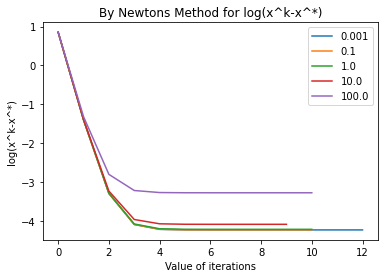

In [54]:
for j in range(len(k2)):
  plt.plot([i for i in range(k2[j])],xvalues1[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(x^k-x^*)')
  plt.title('By Newtons Method for log(x^k-x^*)')
  plt.legend(lam)
plt.show()

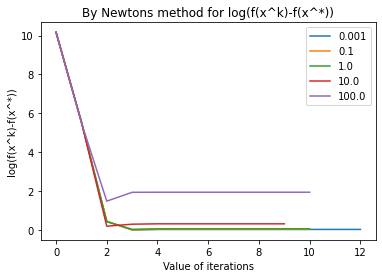

In [55]:
for j in range(len(k2)):
  plt.plot([i for i in range(k2[j])],fvalues1[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(f(x^k)-f(x^*))')
  plt.legend(lam)
  plt.title('By Newtons method for log(f(x^k)-f(x^*))')
plt.show()


$\large\textbf{Ans 6 : }$  here we saw above in both graphs that the sequence are converging towards a particular value. hence both sequences are Q-linear,Q superlinear and Q-quadratic . Also we can see that no. of iterations decrease constantly. and  Also we can see that no. of iterations decrease constantly. We see as the value of lambda reduces the variance of the graph.

In [56]:
alpha = 0.9
rho = 0.5
gamma = 0.5
my_tol= 1e-5
k3=[]
xvalues2=[]
fvalues2=[]
time_taken_bfgs=[]
my_start_x =np.zeros((2,1))
lam=np.array([10**(-3),0.1,1.0,10.0,100.0])
for i in lam:
  start=timer()
  x, k, x_array_newton, f_array_newton = find_minimizer_BFGS_scaling2(my_start_x,i, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
  end=timer()
  print('for lambda',i,':\nwe have minimizer:',x ,'\nno. of iterations:',k, '\n log(x^k-x^*):',x_array_newton , '\n log(x^k-x^*):',f_array_newton)
  k3.append(k)
  xvalues2.append(x_array_newton)
  fvalues2.append(f_array_newton)
  time_taken_bfgs.append(end-start)

for lambda 0.001 :
we have minimizer: [[-1.23958813]
 [ 1.97527023]] 
no. of iterations: 12 
 log(x^k-x^*): [0.8525346660976074, 0.11012521437324793, 0.10949892410516097, -0.6121127763978507, -2.7074827053712274, -3.929543081817814, -4.191323941150235, -4.2211588424591815, -4.22418454155892, -4.224487539721168, -4.22451784382612, -4.224520874279505] 
 log(x^k-x^*): [10.169328129669452, 8.671309623228735, 8.670432364141645, 7.200177014830346, 2.515264964168155, -0.10192856249480185, 0.03519711394703193, 0.03647768719314511, 0.03649048464803595, 0.03649061262179287, 0.036490613901197136, 0.03649061391347381]
for lambda 0.1 :
we have minimizer: [[-1.2395751]
 [ 1.97525  ]] 
no. of iterations: 13 
 log(x^k-x^*): [0.8525346660976074, 0.11012521437324793, 0.1094989314720588, -0.6120878712136377, -2.7071397170399005, -3.928378377858727, -4.189849877856696, -4.219646592403961, -4.222668391330771, -4.222970998655147, -4.2230012636681025, -4.223004290212212, -4.223004441539615] 
 log(x^k-x^*): [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


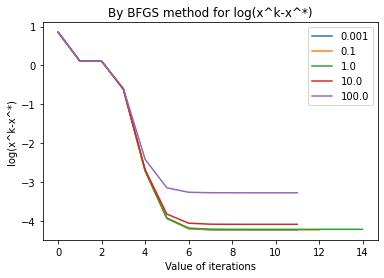

In [57]:
for j in range(len(k3)):
  plt.plot([i for i in range(k3[j])],xvalues2[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(x^k-x^*)')
  plt.title('By BFGS method for log(x^k-x^*)')
  plt.legend(lam)
plt.show()

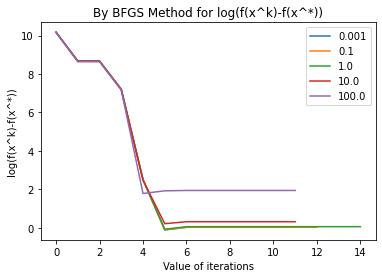

In [58]:
for j in range(len(k3)):
  plt.plot([i for i in range(k3[j])],fvalues2[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(f(x^k)-f(x^*))')
  plt.title('By BFGS Method for log(f(x^k)-f(x^*))')
  plt.legend(lam)
plt.show()

$\large\textbf{Ans 6 : }$ here we saw above in both graphs that the sequence are converging towards a particular value. hence both sequences are Q-linear,Q superlinear and Q-quadratic . Also we can see that no. of iterations decrease constantly. and also we saw  in BFGS method convergence is slow as compared to newtons method. Hence the value of iterations increases or converges slowly for BFGS method.

$\Large\textbf{Ans7}$

We can see by running for different number of rows of A that time taken by both the methods increases with considerable amount.As we see the values of no. of rows increases then time taken also increases.